# Titanic Data Science Solutions

### References: 

[Tutorial Walkthrough](https://www.kaggle.com/startupsci/titanic-data-science-solutions/notebook)  
[Jupyter notebook - solution](https://github.com/Speedml/notebooks/blob/master/titanic/titanic-data-science-solutions-refactor.ipynb)  

### Problem

Create a model to determine, based on a given test dataset (not containing the survival information), if these passengers in the test dataset survived or not.

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# load data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
df_train.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [6]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Analyze by Describing the Data

**Which features are categorical?**

These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based? Among other things this helps us select the appropriate plots for visualization.

- Categorical: Survived, Sex, and Embarked. 
- Ordinal: Pclass.

**Which features are numerical?**

These values change from sample to sample. Within numerical features are the values discrete, continuous, or timeseries based? Among other things this helps us select the appropriate plots for visualization.

- Continous: Age, Fare. 
- Discrete: SibSp, Parch.

**Which features are mixed data types?**

Numerical, alphanumeric data within same feature. These are candidates for correcting goal.

- Ticket is a mix of numeric and alphanumeric data types. Cabin is alphanumeric.

**Which features may contain errors or typos?**

This is harder to review for a large dataset, however reviewing a few samples from a smaller dataset may just tell us outright, which features may require correcting.

- Name feature may contain errors or typos as there are several ways used to describe a name including titles, round brackets, and quotes used for alternative or short names.

**Which features contain blank, null or empty values?**

These will require correcting.

- Cabin > Age > Embarked features contain a number of null values in that order for the training dataset.
- Cabin > Age are incomplete in case of test dataset.

**What are the data types for various features?**

- Seven features are integer or floats. Six in case of test dataset.
- Five features are strings (object).

**What is the distribution of numerical feature values across the samples?**

This helps us determine, among other early insights, how representative is the training dataset of the actual problem domain.

- Total samples are 891 or 40% of the actual number of passengers on board the Titanic (2,224).
- Survived is a categorical feature with 0 or 1 values.
- Around 38% samples survived representative of the actual survival rate at 32%.
- Most passengers (> 75%) did not travel with parents or children.
- Nearly 30% of the passengers had siblings and/or spouse aboard.
- Fares varied significantly with few passengers (<1%) paying as high as $512.
- Few elderly passengers (<1%) within age range 65-80.

**What is the distribution of categorical features?**

- Names are unique across the dataset (count=unique=891)
- Sex variable as two possible values with 65% male (top=male, freq=577/count=891).
- Cabin values have several dupicates across samples. Alternatively several passengers shared a cabin.
- Embarked takes three possible values. S port used by most passengers (top=S)
- Ticket feature has high ratio (22%) of duplicate values (unique=681).

### Assumtions based on data analysis

We arrive at following assumptions based on data analysis done so far. We may validate these assumptions further before taking appropriate actions.

**Correlating.**

We want to know how well does each feature correlate with Survival. We want to do this early in our project and match these quick correlations with modelled correlations later in the project.

**Completing.**

1. We may want to complete Age feature as it is definitely correlated to survival.
2. We may want to complete the Embarked feature as it may also correlate with survival or another important feature.

**Correcting.**

1. Ticket feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.
2. Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset.
3. PassengerId may be dropped from training dataset as it does not contribute to survival.
4. Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.

**Creating.**

1. We may want to create a new feature called Family based on Parch and SibSp to get total count of family members on board.
2. We may want to engineer the Name feature to extract Title as a new feature.
3. We may want to create new feature for Age bands. This turns a continous numerical feature into an ordinal categorical feature.
4. We may also want to create a Fare range feature if it helps our analysis.

**Classifying.**

We may also add to our assumptions based on the problem description noted earlier.

1. Women (Sex=female) were more likely to have survived.
2. Children (Age<?) were more likely to have survived. 
3. The upper-class passengers (Pclass=1) were more likely to have survived.

We can quickly analyze our observations, e.g. more 1st class passengers survived, women had a higher survival rate, by pivoting features against 'Survived'.  We can only do so at this stage for features which do not have any empty values. It also makes sense doing so only for features which are categorical (Sex), ordinal (Pclass) or discrete (SibSp, Parch) type.

In [7]:
# Survival vs Passenger Class - correlation between passenger class and survival
pivot = df_train[['Pclass', 'Survived']]
pivot = pivot.groupby(['Pclass'], as_index=False).mean()
pivot.sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [8]:
# Survival vs Gender - correlation between gender and survival
pivot = df_train[["Sex", "Survived"]]
pivot = pivot.groupby(['Sex'], as_index=False).mean()
pivot.sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [9]:
# 'SibSp' vs 'Survived' - little correlation
pivot = df_train[['SibSp', 'Survived']]
pivot = pivot.groupby(['SibSp'], as_index=False).mean()
pivot.sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [10]:
# 'Parch' vs 'Survived' - little correlation
pivot = df_train[['Parch', 'Survived']]
pivot = pivot.groupby(['Parch'], as_index=False).mean()
pivot.sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


With `Parch` and `SibSp` it may be best to derive a feature or a set of features from these individual features.

### Confirm assumptions by visualizing the data

#### Plot a histogram of 'Age' vs 'Survived'

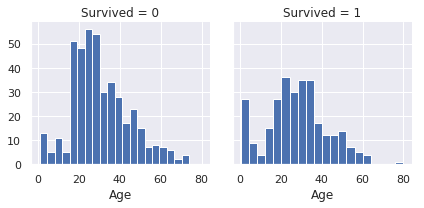

In [11]:
plot = sns.FacetGrid(df_train, col='Survived')
plot.map(plt.hist, 'Age', bins=20);

##### Observations

- Infants (Age <=4) had high survival rate.
- Oldest passengers (Age = 80) survived.
- Large number of 15-25 year olds did not survive.
- Most passengers are in 15-35 age range.

This simple analysis confirms our assumptions as decisions for subsequent workflow stages.

- We should consider Age in our model training.
- Complete the Age feature for null values.
- We should band age groups.

#### Plot Passenger Class vs Survived

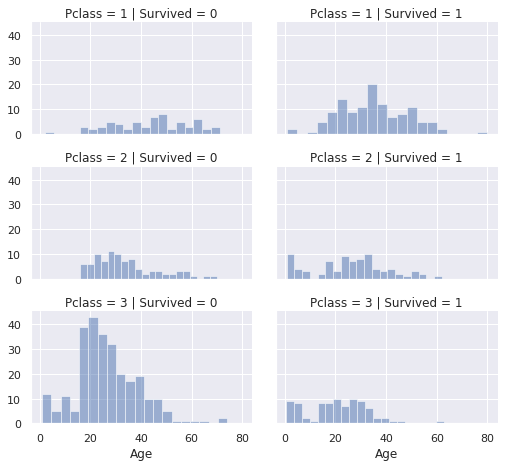

In [15]:
plot = sns.FacetGrid(df_train, col='Survived', row='Pclass', height=2.2, aspect=1.6)
plot.map(plt.hist, 'Age', alpha=0.5, bins=20)
plot.add_legend();

##### Observations

- Pclass=3 had most passengers, however most did not survive.
- Infant passengers in Pclass=2 and Pclass=3 mostly survived.
- Most passengers in Pclass=1 survived.
- Pclass varies in terms of Age distribution of passengers.

### Correlating Categorical Data

/media/theboymo/d64061fd-29fa-457c-8209-b6a7ed06885f/home/theboymo/MiniConda/envs/ml37/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/media/theboymo/d64061fd-29fa-457c-8209-b6a7ed06885f/home/theboymo/MiniConda/envs/ml37/lib/python3.7/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


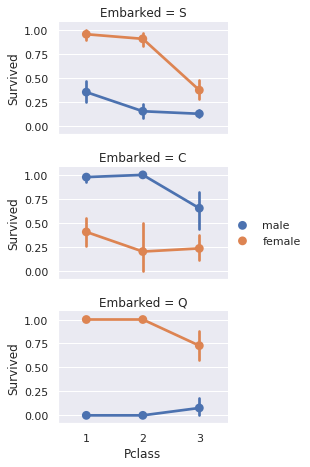

In [22]:
plot = sns.FacetGrid(df_train, row='Embarked', height=2.2, aspect=1.6)
plot.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
plot.add_legend();

##### Observations

- Female passengers had much better survival rate than males.
- Exception in Embarked=C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and Survived, not necessarily direct correlation between Embarked and Survived.
- Males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports.
- Ports of embarkation have varying survival rates for Pclass=3 and among male passengers.

### Correlating categorical and numerical features

We may also want to correlate categorical features (with non-numeric values) and numeric features. We can consider correlating Embarked (Categorical non-numeric), Sex (Categorical non-numeric), Fare (Numeric continuous), with Survived (Categorical numeric).

/media/theboymo/d64061fd-29fa-457c-8209-b6a7ed06885f/home/theboymo/MiniConda/envs/ml37/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


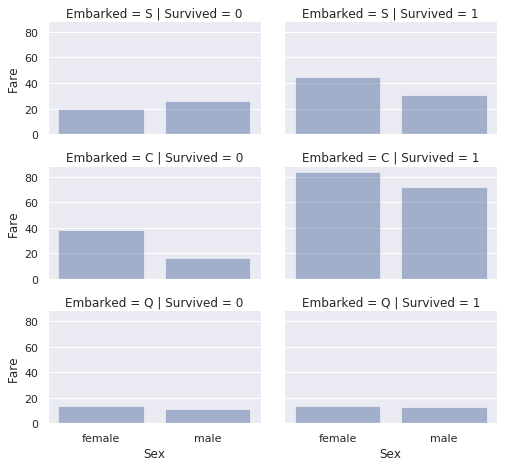

In [24]:
plot = sns.FacetGrid(df_train, row='Embarked', col='Survived', height=2.2, aspect=1.6)
plot.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
plot.add_legend();

#### Observations

- Higher fare paying passengers had better survival.
- Port of embarkation correlates with survival rates. 

### Conclusions

- We should consider Age in our model training.
- Complete the Age feature for null values).
- We should band age groups.
- Consider Pclass for model training.
- Add Sex feature to model training.
- Complete and add Embarked feature to model training.
- Consider banding Fare feature.

In [12]:
# store target variable & combine both data sets
survived_train = df_train.Survived
data = pd.concat([df_train.drop(['Survived'], axis=1), df_test])
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
